In [1]:
%%time
import pandas as pd
import numpy as np
import os               # to calculate file sizes
import re               # to use regex (filenames)
import io               # to simulate saving plots in files
import math             # to calculate factorials (combinations)
import itertools        # to iterate through combinations
from timeit import time # to measure running time
import xlsxwriter       # to write xlsx files

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)
def nPr(n,r):
    f = math.factorial
    return f(n) / f(n-r)
def sizeof_fmt(df, suffix='B'):
    if type(df)==pd.core.frame.DataFrame:
        num=df.values.nbytes + df.index.nbytes + df.columns.nbytes
    else:
        num=df
    for unit in ['','k','M','G','T','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s" % (num, suffix)
%matplotlib inline

Wall time: 3.15 s


In [2]:
tested_files = ["150727 LFA1.csv", "150728 VBAK.csv", "150728 RBKP.xlsx"]

imported_filename= tested_files[1]
imported_filename_extension = re.search('\.(\w+)$',imported_filename).group(1)
time_start_loading = time.time()

if imported_filename_extension=='csv':
    df_source=pd.read_csv(imported_filename, sep=";", encoding="CP1250", decimal=",", thousands=" ")
elif imported_filename_extension=='xlsx':
    df_source=pd.read_excel(imported_filename)
else:
    raise ValueError ('Extension of imported file (%s) is not supported.' %(imported_filename_extension))    
print("File %s loaded in %.1fs. Working set size %s" %( imported_filename, time.time()-time_start_loading, sizeof_fmt(df_source)))

File 150728 VBAK.csv loaded in 0.6s. Working set size 17.7MB


C:\Users\mwistuba\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (6,9,27,57,82,83,86,109,112,113,115,124) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
%%time
df_source_size = len(df_source.index)
df_columns_descriptor = pd.DataFrame({'Column'   : df_source.columns, 
                   'Uniques'  : [df_source[col].unique().size for col in df_source.columns],
                   'NotNulls' : [df_source[col].notnull().values.sum() for col in df_source.columns],
#                   'Type'     : [str(type(df_source[col].ix[0])) for col in df_source.columns],
                   'Type'     : [str(df_source[col].dtype) for col in df_source.columns],
                   'Freq_table'          : [pd.DataFrame for col in df_source.columns],
                   'Dispersion'  : [0.0 for col in df_source.columns], 
                      })
df_columns_descriptor['Uniques%']=(df_columns_descriptor['Uniques'])/(df_columns_descriptor['NotNulls']+1*(df_source_size>df_columns_descriptor['NotNulls']))
df_columns_descriptor['NotNulls%']=df_columns_descriptor['NotNulls']/df_source_size

Wall time: 120 ms


In [4]:
%%time

# define function to return top frequencies
def provtop(dset):
    if dset.empty==True:
        return [dset, 0]
    max_rows_returned=15
    dfret = pd.DataFrame
    dispersion = 0.0

    # converting to lowercase strings etc.
    if dset.dtype=='O':
        dset=dset.astype(str)
        dset=dset.str.strip().str.lower() #.str.replace(' ', '_')
        
    dfret=dset.value_counts(sort=True)
    
    # reducing output text width
    if dset.dtype=='O':
        dfret.index=dfret.index.astype(str).str[0:12]
    
    sumfreq = dfret.sum()
    dispersion = 1-sum((dfret/sumfreq)**2)
    dfret=dfret.to_frame('Freq').head(max_rows_returned).T
    return [dfret, dispersion]

df_columns_descriptor.loc[:,['Freq_table','Dispersion']] = [provtop(df_source[col]) for col in df_source.columns]


Wall time: 1.32 s


In [5]:
df_columns_descriptor=pd.concat([df_columns_descriptor, pd.DataFrame(columns=['Min','Q5%','Mean','Q95%','Max'])])
df_columns_descriptor.loc[:,['Min','Q5%','Mean','Q95%','Max']]=[([min(df_source[col]),df_source[col].quantile(0.05), df_source[col].quantile(0.5), df_source[col].quantile(0.95), max(df_source[col])] 
     if df_source[col].dtype!='object' 
     else [np.NaN]*5) for col in df_source.columns]

C:\Users\mwistuba\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [6]:
%%time
descriptors = ['10 Level 1 index.', '15 Possible good categorizer.', '30 No comments', '80 Mostly empty (98%+).', '90 Single value column.', '99 Empty column.']

df_columns_descriptor.loc[(df_columns_descriptor['Uniques']==df_source_size), 'Data category']=descriptors[0]
df_columns_descriptor.loc[((df_columns_descriptor['Uniques']<50) & \
                           (df_columns_descriptor['Dispersion']>0.2) & \
                           (df_columns_descriptor['NotNulls%']>0.9)),'Data category']= descriptors[1]
df_columns_descriptor.loc[((df_columns_descriptor['NotNulls%']<0.02) & \
                           (df_columns_descriptor['NotNulls%']>0)), 'Data category']= descriptors[3]
df_columns_descriptor.loc[((df_columns_descriptor['NotNulls']==df_source_size) & \
                           (df_columns_descriptor['Uniques']==1)), 'Data category']=descriptors[4]
df_columns_descriptor.loc[(df_columns_descriptor['NotNulls%']==0), 'Data category']= descriptors[5]
df_columns_descriptor.loc[(df_columns_descriptor['Data category'].isnull()),'Data category']=descriptors[2]

df_columns_descriptor['Data category']=df_columns_descriptor['Data category'].astype('category', categories=descriptors, ordered=True)

Wall time: 10 ms


In [7]:
%%time

cols_q=df_columns_descriptor.loc[df_columns_descriptor['Data category'].isin(['15 Possible good categorizer.']),'Column'].as_matrix()

tempArr=[]

for a,b in itertools.permutations(cols_q,2):
    tempArr.append([a,b,0])
df_Cramers_V = pd.DataFrame(tempArr, columns=['Col1','Col2', 'V coeff'])

from scipy import stats as ss

for col1, col2 in itertools.combinations(cols_q,2):
    myf=pd.pivot_table(df_source, index=[col1], columns=[col2], values=df_columns_descriptor.iloc[0,0], aggfunc=len, fill_value=0)
    chi2, p, df, ext = ss.chi2_contingency(myf)
    n=myf.sum().sum()
    cramers_v = math.sqrt((chi2/n)/min(len(myf)-1,len(myf.columns)-1))    
    df_Cramers_V.loc[(df_Cramers_V['Col1']==col1) & (df_Cramers_V['Col2']==col2)] = [col1, col2, cramers_v]

df_Cramers_V_high_assoc_columns = df_Cramers_V.loc[df_Cramers_V['V coeff']>0.8,['Col1','Col2']].unstack().unique()


Wall time: 1.78 s


In [8]:
df_Cramers_V=df_Cramers_V.pivot('Col1','Col2','V coeff').T+df_Cramers_V.pivot('Col1','Col2','V coeff')

In [12]:
%%time

df_columns_descriptor=df_columns_descriptor.loc[:,['Column','Data category', 'NotNulls', 'Uniques', 'NotNulls%', 'Uniques%', 'Dispersion', 'Type', 'Min','Q5%','Mean','Q95%','Max', 'Freq_table']]

column_no_stats = 9
column_no_frequencies=9+5
column_no_cramer = 26+5

workbook  = xlsxwriter.Workbook('data_description.xlsx', options={'nan_inf_to_errors': True})
format_title = workbook.add_format({'bold': True, 'font_color': 'black', 'font_size' : 16})
format_head1 = workbook.add_format({'bold': True, 'font_color': 'black', 'font_size' : 14})
format_dataH1 = workbook.add_format({'bold': True, 'font_color': 'black', 'font_size' : 12})
format_perc= workbook.add_format({'num_format' : '0.0%;-0.0%;-'})

worksheet = workbook.add_worksheet('Main')

sort_by = 'Data category'

worksheet.write(0,0, "Data description report", format_title)
worksheet.write(1,0, "File : %s, %d rows and %d columns." %(imported_filename, len(df_source.index), len(df_source.columns)))
worksheet.write(2,0, "File size : %s. Working set size: %s" %(sizeof_fmt(os.path.getsize(imported_filename)), sizeof_fmt(df_source)))
worksheet.write(3,0, "Sorted by: %s" %(sort_by))
worksheet.write(3,column_no_stats, "Basic statistics")
worksheet.write(3,column_no_frequencies, "Frequencies tables")
worksheet.write(3,column_no_cramer, "Cramer's V coefficients")


for col in [[0,3],[1,12],[2,24],[8,12]]:worksheet.set_column(col[0],col[0],col[1])

row_no =5
worksheet.write_row(row_no, 1, df_columns_descriptor.columns, format_dataH1)
worksheet.write_row(row_no, column_no_cramer, df_Cramers_V.columns, format_dataH1)

row_no +=1
worksheet.freeze_panes(row_no, 4)

for index, row in df_columns_descriptor.sort_values(by=sort_by).iterrows():
    row_data = row[row.index.drop('Freq_table')]
    worksheet.write(row_no, 0, index)
    worksheet.write_row(row_no, 1, row_data.fillna('-'))
    
#    row_no +=1
    
    worksheet.write(row_no, column_no_frequencies, "Label", format_dataH1)
    worksheet.write_row(row_no, column_no_frequencies+1, row['Freq_table'].axes[1])
    
    if row['Column'] in df_Cramers_V.columns:
        worksheet.write_row(row_no, column_no_cramer, df_Cramers_V[row['Column']].fillna('-'))
    
    row_no +=1
    
    worksheet.write(row_no, column_no_frequencies, "Count", format_dataH1)
    worksheet.write_row(row_no,  column_no_frequencies+1, row['Freq_table'].values.flatten())
    row_no +=1                 
    
worksheet.conditional_format(5,5,row_no,5, {'type': '3_color_scale'})
worksheet.conditional_format(5,6,row_no,6, {'type': '3_color_scale'})
worksheet.conditional_format(5,7,row_no,7, {'type': '3_color_scale'})

worksheet.set_column(5,7, 8, format_perc)
    
#worksheet.set_column('B:G', None, None, {'level': 1, 'hidden': True})
worksheet.set_column('K:Z', None, None, {'level': 1, 'collapsed': True,  'hidden': True})
worksheet.set_zoom(70)

worksheet.conditional_format(5,column_no_cramer,row_no,column_no_cramer+len(df_Cramers_V.columns), {'type': '3_color_scale'})
worksheet.set_column(column_no_cramer,column_no_cramer+len(df_Cramers_V.columns), 8, format_perc)

# Close the Pandas Excel writer and output the Excel file.
workbook.close()

Wall time: 923 ms


C:\Users\mwistuba\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


ValueError: range parameter must be finite.

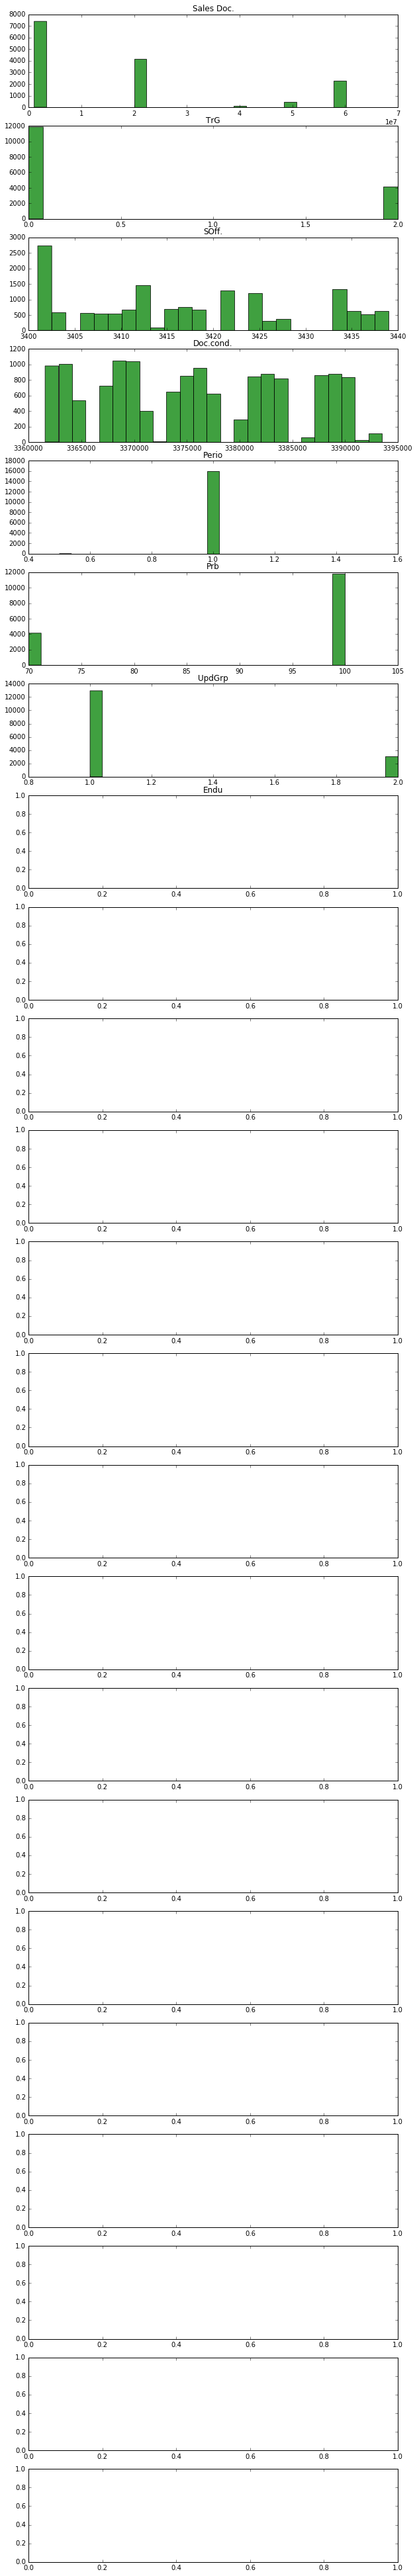

In [10]:
%timeit
import matplotlib.pyplot as plt
from matplotlib import gridspec

cols_q=df_columns_descriptor.loc[(df_columns_descriptor['Type'].isin(('int64','float64'))) &
                                 ~(df_columns_descriptor['Data category'].isin(['80 Mostly empty (98%+).', 
                                                                                '90 Single value column.', 
                                                                                '99 Empty column.'])),
                                 'Column'].values.tolist()
#cols_q=['Gross amnt', 'Del.costs', 'VAT']
fig, axes = plt.subplots(nrows=len(cols_q), figsize=(10, 3*len(cols_q)))

for c in range(len(cols_q)):
    axes[c].set_title(cols_q[c])
    plt.ylabel='Frequency'
    plt.xlabel=cols_q[c]
    axes[c].hist(df_source[cols_q[c]], range=tuple(df_source[cols_q[c]].quantile([.05,.95]).tolist()), bins=25, facecolor='g', alpha=0.75)


worksheet = workbook.add_worksheet('Histograms')

buf=io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
image_data = io.BytesIO(buf.read())
buf.close()
worksheet.insert_image("A1", 'temp.png', {'image_data': image_data})

workbook.close()


In [ ]:
pd.pivot_table(df_source, index=['OrBlT'], columns=['SaTy'], aggfunc=len, fill_value=0, values=['Sales Doc.'])